In [60]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.io as scipy
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import label as connected_components
from ipywidgets import interact, Dropdown
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA, NMF

ims_cube = scipy.loadmat("ims_cube.mat")['ims_cube']

# 1. Data Understanding
## 1.1 Plot der räumlichen Verteilung einzelner Features/Kanäle
*Beim Dropdown "Channels" lassen sich je 6 Bilder oder auch alle auf einmal ausgeben:*

In [ ]:
# Print basic information
print(f"Shape of ims_cube: {ims_cube.shape}")

n_channels = ims_cube.shape[2]
print(f"Number of channels: {n_channels}")

# Plot channels
def plot_channels(preset_group):
    # Plot all channels in a dynamic grid
    if preset_group == "All Channels":
        channels_to_show = list(range(n_channels))
        cols = 4  # Adjust as needed
        rows = (n_channels + cols - 1) // cols  # Ceiling division
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
        
        # Handle different subplot configurations
        if n_channels == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if hasattr(axes, '__iter__') else [axes]
        else:
            axes = axes.ravel()
        
        for i, channel_idx in enumerate(channels_to_show):
            im = axes[i].imshow(ims_cube[:, :, channel_idx], cmap='viridis')
            axes[i].set_title(f'Channel {channel_idx + 1}')  # Changed to 1-based indexing
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i])
        
        # Hide unused subplots
        for i in range(n_channels, rows * cols):
            if i < len(axes):
                axes[i].set_visible(False)

    # Plot up to 6 plots at once
    else:
        # Parse the preset group to get channel range
        group_start = int(preset_group.split('-')[0]) - 1  # 0-based indexing
        group_end = min(group_start + 6, n_channels)
        channels_to_show = list(range(group_start, group_end))
        
        cols = 3
        rows = 2
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
        axes = axes.ravel()
        
        for i, channel_idx in enumerate(channels_to_show):
            im = axes[i].imshow(ims_cube[:, :, channel_idx], cmap='viridis')
            axes[i].set_title(f'Channel {channel_idx + 1}')  # 1-based indexing
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i])
        
        # Hide unused subplots
        for i in range(len(channels_to_show), 6):
            axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Create preset groups
preset_options = ["All Channels"] 
for i in range(0, n_channels, 6):
    start = i + 1
    end = min(i + 6, n_channels)
    preset_options.append(f"{start}-{end}")

# Create widget
preset_selector = Dropdown(
    options=preset_options,
    value=preset_options[1], 
    description='Channels:',
    disabled=False,
)

# Interactive widget
interact(plot_channels, preset_group=preset_selector)

Shape of ims_cube: (128, 128, 191)
Number of channels: 191


interactive(children=(Dropdown(description='Channels:', index=1, options=('All Channels', '1-6', '7-12', '13-1…

<function __main__.plot_channels(preset_group)>

___
## 1.2 Plot der enthaltenen Spektren


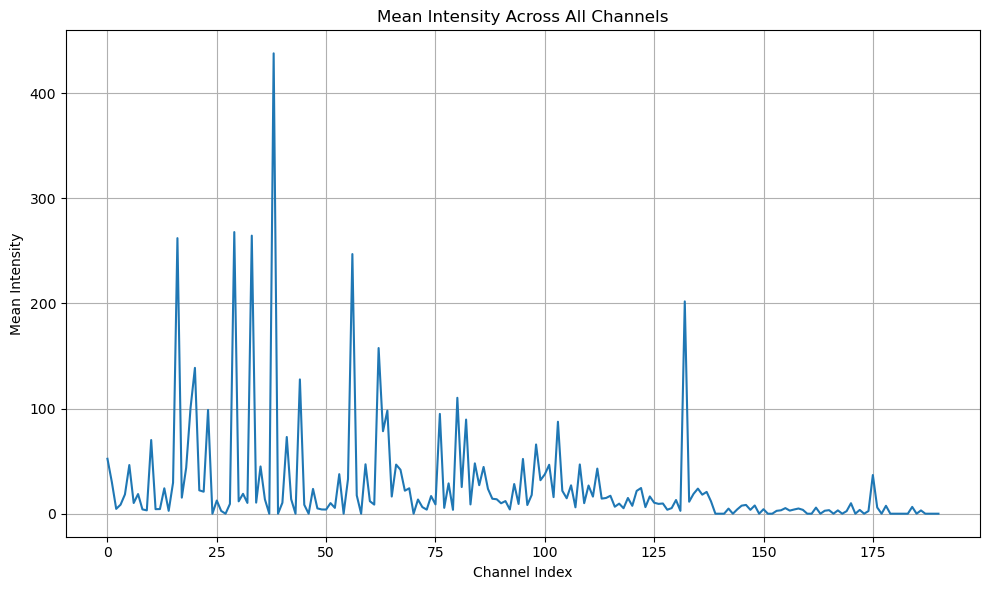

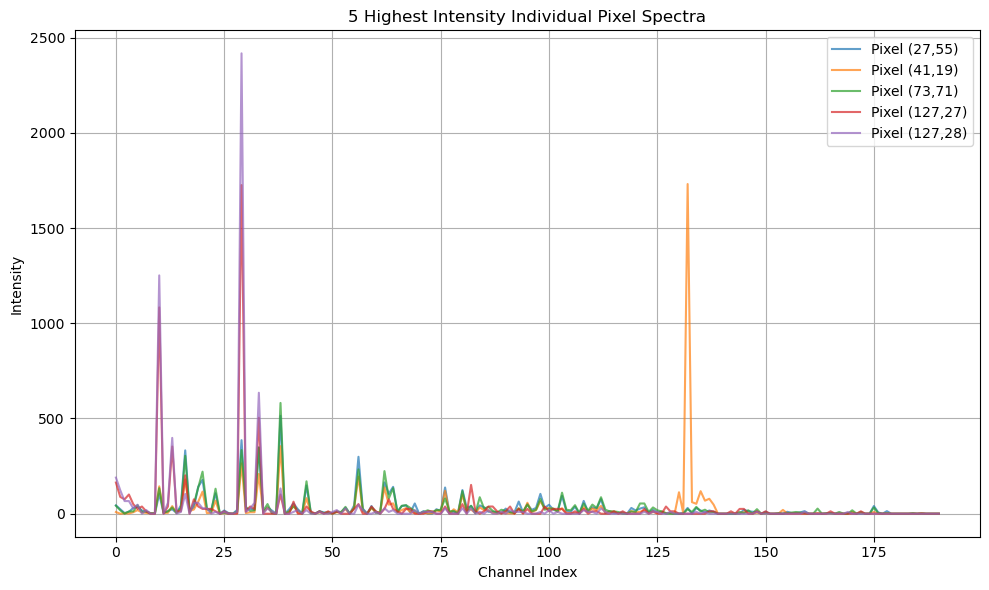

In [62]:
# Plot mean intensity across all channels
plt.figure(figsize=(10, 6))
mean_intensity = np.mean(ims_cube, axis=(0, 1))
plt.plot(mean_intensity)
plt.title('Mean Intensity Across All Channels')
plt.xlabel('Channel Index')
plt.ylabel('Mean Intensity')
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot spectra for the highest peaks (possibly most interesting)
plt.figure(figsize=(10, 6))
n_samples = 5

# Extract height and width from ims_cube shape
height, width = ims_cube.shape[:2]

# Find pixels with highest overall intensity
pixel_sums = np.sum(ims_cube, axis=2)  # Sum across all channels for each pixel
flat_indices = np.argsort(pixel_sums.ravel())[-n_samples:]  # Get top n_samples pixels

for i, flat_idx in enumerate(flat_indices):
    # Convert flat index back to 2D coordinates
    row, col = np.unravel_index(flat_idx, (height, width))
    spectrum = ims_cube[row, col, :]
    plt.plot(spectrum, alpha=0.7, label=f'Pixel ({row},{col})')

plt.title('5 Highest Intensity Individual Pixel Spectra')
plt.xlabel('Channel Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Eckdaten zur Spektralanalyse

#### a) für das durchschnittliche Spektrum:

In [63]:
print(f"=== AVERAGE SPECTRUM SPECTRAL ANALYSIS ===\n")
print(f"Min intensity: {np.min(mean_intensity):.3f}")
print(f"Max intensity: {np.max(mean_intensity):.3f}")
print(f"Mean intensity: {np.mean(mean_intensity):.3f}")
print(f"Std deviation: {np.std(mean_intensity):.3f}")

# Find peaks
peak_indices = []
for i in range(1, len(mean_intensity)-1):
    if mean_intensity[i] > mean_intensity[i-1] and mean_intensity[i] > mean_intensity[i+1]:
        peak_indices.append(i)

if peak_indices:
    peak_values = mean_intensity[peak_indices]
    # Get top 3 peaks
    top_peaks_idx = np.argsort(peak_values)[-3:][::-1]
    top_peak_channels = [peak_indices[i] for i in top_peaks_idx]
    top_peak_values = [peak_values[i] for i in top_peaks_idx]
    print(f"Top peaks at channels: {top_peak_channels} "
          f"with values: {[f'{val:.3f}' for val in top_peak_values]}")

# Find global maximum
max_channel = np.argmax(mean_intensity)
print(f"Global maximum at channel {max_channel}: {mean_intensity[max_channel]:.3f}")

# Find global minimum
min_channel = np.argmin(mean_intensity)
print(f"Global minimum at channel {min_channel}: {mean_intensity[min_channel]:.3f}")


=== AVERAGE SPECTRUM SPECTRAL ANALYSIS ===

Min intensity: 0.000
Max intensity: 437.762
Mean intensity: 27.321
Std deviation: 54.405
Top peaks at channels: [38, 29, 33] with values: ['437.762', '267.803', '264.411']
Global maximum at channel 38: 437.762
Global minimum at channel 24: 0.000


#### b) für den gesamten Datensatz:

In [64]:
print("=== DATASET OVERVIEW ===")
print(f"Total number of spectra (pixels): {height * width}")
print(f"Number of spectral channels: {n_channels}")
print(f"Overall min intensity: {np.min(ims_cube):.3f}")
print(f"Overall max intensity: {np.max(ims_cube):.3f}")
print(f"Overall mean intensity: {np.mean(ims_cube):.3f}")
print(f"Overall std deviation: {np.std(ims_cube):.3f}")
print()


# Channel-wise statistics
channel_means = np.mean(ims_cube, axis=(0,1))
channel_stds = np.std(ims_cube, axis=(0,1))

most_variable_channel = np.argmax(channel_stds)
least_variable_channel = np.argmin(channel_stds)

print(f"Most variable channel: {most_variable_channel} (std: {channel_stds[most_variable_channel]:.3f})")
print(f"Least variable channel: {least_variable_channel} (std: {channel_stds[least_variable_channel]:.3f})")

=== DATASET OVERVIEW ===
Total number of spectra (pixels): 16384
Number of spectral channels: 191
Overall min intensity: 0.000
Overall max intensity: 2417.062
Overall mean intensity: 27.321
Overall std deviation: 64.665

Most variable channel: 132 (std: 405.127)
Least variable channel: 24 (std: 0.000)


___
## 1.3 Erkenntnisse aus der Datenanalyse

| **Beobachtung** | **Konsequenz für die Datenverarbeitung** |
| :--- | :--- |
| *Datenformat* (Dimension) | Die 128x128-Bilder müssen in eine 2D-Matrix umgewandelt werden, damit sie verarbeitet werden können (für Clustering, PCA, usw. zwingend nötig). |
| *Dynamikbereich*: Große Amplitudenunterschiede | *Normalisierung/Standardisierung*: Skalierung der Daten ist zwingend, um sicherzustellen, dass alle Features / Dimensionen gleich behandelt werden |
| *Heterogenität*: Kanäle zeigen unterschiedliche räumliche Muster | ggf. *Feature Selection* zur Identifikation der informativsten Kanäle |
| *Korrelation*: Ähnliche Strukturen deuten auf Redundanz hin | ggf. *Dimensionsreduktion* zur Entfernung redundanter Informationen |


___
___
# 2. Data Preparation
## 2.1 Datenumformung

### Umwandlung des 3D-Datenwürfels in eine 2D Matrix

In [65]:
# Reshape data cube into 2D matrix (samples x features)
# Each pixel becomes a sample, each channel becomes a feature

print(f"Original shape: {ims_cube.shape}")

X = ims_cube.reshape(-1, n_channels)

print(f"Reshaped matrix shape: {X.shape}")
print(f"Number of samples (pixels): {X.shape[0]}")
print(f"Number of features (channels): {X.shape[1]}")

# Verify the transformation
print(f"\nVerification:")
print(f"Original total pixels: {height} * {width} = {height * width}")
print(f"Matrix samples: {X.shape[0]}")

Original shape: (128, 128, 191)
Reshaped matrix shape: (16384, 191)
Number of samples (pixels): 16384
Number of features (channels): 191

Verification:
Original total pixels: 128 * 128 = 16384
Matrix samples: 16384


___
## 2.2 Datenstandardisierung

### Zentrierung auf Mittelwert Null und Skalierung auf Einheitsvarianz

In [66]:
# Standardize the features with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Standardized matrix shape: {X_scaled.shape}\n")

# Verify standardization per feature
print(f"Verifying with example values (first 15):")
print(" Per-feature means:", np.round(np.mean(X_scaled, axis=0)[:15],3))
print(" Per-feature stds:", np.std(X_scaled, axis=0)[:15])

Standardized matrix shape: (16384, 191)

Verifying with example values (first 15):
 Per-feature means: [ 0.  0. -0.  0.  0. -0.  0.  0. -0.  0.  0.  0. -0. -0.  0.]
 Per-feature stds: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


___
___
# 3. Modeling & Evaluation: Clustering
## 3.1 Verfahrensauswahl
### Modellierung: k-Means Clustering für MSI-Daten

| Aspekt | k-Means Clustering (Ausgewähltes Verfahren) | Alternative Verfahren (DBSCAN, GMM, Hierarchical, etc.) |
| :--- | :--- | :--- |
| **Grundprinzip** | Gruppiert bei MSI-Daten alle Pixel in eine vorher festgelegte Anzahl (k) von Clustern, die jeweils ein bestimmtes Material oder Gewebe repräsentieren sollen. Dabei wird jedes Pixel dem Cluster-Zentrum zugeordnet, dessen durchschnittliches Spektrum seinem eigenen Spektrum am ähnlichsten ist. Durch diesen iterativen Prozess entstehen am Ende stabile Gruppen von Pixeln mit sehr ähnlichen spektralen Signaturen. | Nutzen andere Metriken wie Dichte (DBSCAN) oder Wahrscheinlichkeitsverteilungen (GMM). |
| **Eignung für MSI** | **Sehr gut**: Spektrale Ähnlichkeit wird direkt in geringe Distanz übersetzt. Cluster-Zentren sind als "typische" Materialspektren interpretierbar. | **Weniger geeignet**:<br>- DBSCAN hat Schwierigkeiten mit hochdimensionalen Daten und der Parameterwahl (ε).<br>- GMM ist komplexer ohne klaren Vorteil. |
| **Skalierbarkeit** | **Hoch**: Effiziente Komplexität ($O(n \cdot k \cdot i)$) ideal für große MSI-Datensätze mit vielen Pixeln. | **Gering**: <br>- Hierarchical Clustering ($O(n^3)$)<br>- DBSCAN ($O(n^2)$)<br>-  Spectral Clustering ($O(n^3)$)<br> ->sind alle für große Datenmengen zu rechenintensiv. |
| **Parameter** | **Einfach**: Im Wesentlichen muss nur die Anzahl der Cluster (k) bestimmt werden, welche in diesem Anwendungsbeispiel durch Domänenwissen gegeben ist. | **Komplex**: DBSCAN (ε, min_samples), GMM (Anzahl, Kovarianzen) und Spectral Clustering erfordern eine aufwändigere Parameterwahl. |
| **Annahmen** | **Passend**: Annahmen wie sphärische und konvexe Cluster werden durch die Standardisierung der Daten gut unterstützt. | - |
| **Vorteile** | Schnelle Verarbeitung<br>Leicht interpretierbare Ergebnisse<br>Robust bei standardisierten Daten<br>Etabliertes Verfahren | - |
| **Nachteile** | Kann bei stark überlappenden Spektren oder Rauschen an Grenzen stoßen. | Meist zu langsam oder unpraktikabel für die Analyse von MSI-Bildern. |

___
## 3.2 Parametrisierung

#### k=5, da in der Aufgabe die Rede von 5 Gewebearten ist

### Alternativ: k über Silhouette Score festlegen

=== K-MEANS PARAMETER OPTIMIZATION ===
Testing different values of k to find optimal number of clusters...
k=2: Silhouette Score = 0.2527
k=3: Silhouette Score = 0.2125
k=4: Silhouette Score = 0.1321
k=5: Silhouette Score = 0.1278
k=6: Silhouette Score = 0.1034
k=7: Silhouette Score = 0.0934
k=8: Silhouette Score = 0.0715
k=9: Silhouette Score = 0.0710
k=10: Silhouette Score = 0.0660

Optimal k based on silhouette score: 2 (score: 0.2527)


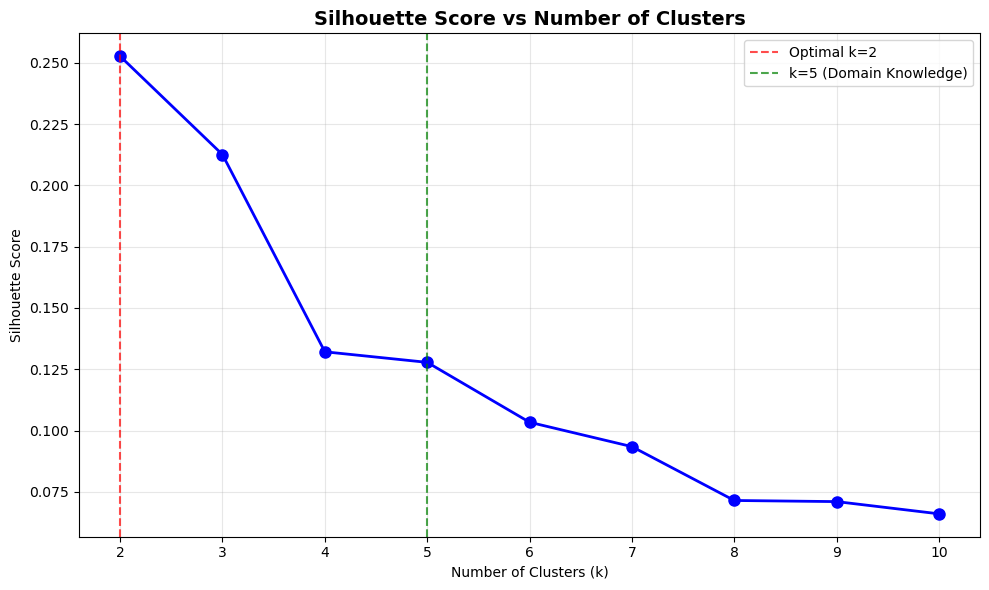

In [72]:
# First, let's do k-means parameter optimization to find the best k
print(f"=== K-MEANS PARAMETER OPTIMIZATION ===")
print("Testing different values of k to find optimal number of clusters...")

k_range = range(2, 11)  # Test k from 2 to 10
silhouette_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    inertias.append(kmeans.inertia_)
    
    print(f"k={k}: Silhouette Score = {silhouette_avg:.4f}")

# Find optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on silhouette score: {optimal_k} (score: {max(silhouette_scores):.4f})")

# Plot optimization results
plt.figure(figsize=(10, 6))

# Silhouette scores
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
plt.axvline(x=5, color='green', linestyle='--', alpha=0.7, label='k=5 (Domain Knowledge)')
plt.title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Auswertung Silhouette Score
Ginge man rein nach dem Silhouette Score, müsste man k=2 oder k=3 wählen. Da 2 Cluster in diesem Kontext wenig Sinn ergeben, lohnt sich eher noch das Ergebnis mit 3 Clustern anzuschauen.

## 3.3 Durchführung und Visualisierung

=== K-MEANS CLUSTERING ANALYSIS ===
Using k=5 clusters as specified
Data shape: (16384, 191)

Silhouette Score: 0.1278

Cluster Distribution:
  Cluster 1: 3,830 pixels (23.4%)
  Cluster 2: 532 pixels (3.2%)
  Cluster 3: 3,463 pixels (21.1%)
  Cluster 4: 6,473 pixels (39.5%)
  Cluster 5: 2,086 pixels (12.7%)


Text(0, 0.5, 'Y coordinate (pixels)')

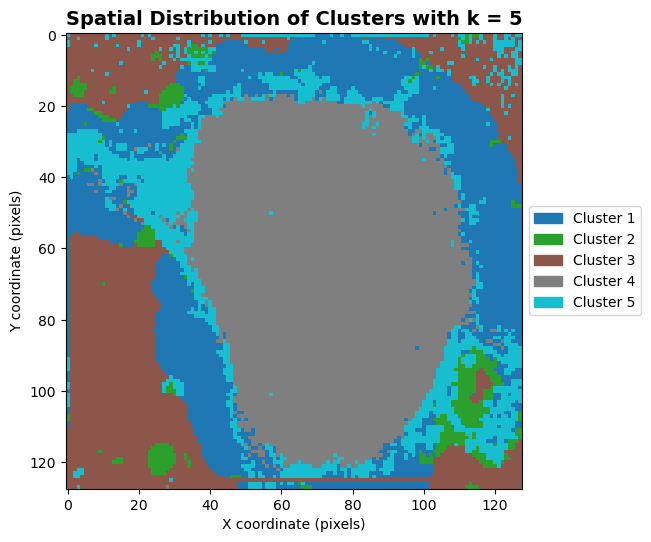

In [73]:
# k-means clustering with k=5
print("=== K-MEANS CLUSTERING ANALYSIS ===")
print(f"Using k=5 clusters as specified")
print(f"Data shape: {X_scaled.shape}")

# Perform clustering
kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X_scaled)

# Calculate performance metrics
silhouette_avg = silhouette_score(X_scaled, labels)

print(f"\nSilhouette Score: {silhouette_avg:.4f}")

# Analyze cluster distribution
unique_labels, counts_k5 = np.unique(labels, return_counts=True)
print(f"\nCluster Distribution:")
for label, count in zip(unique_labels, counts_k5):
    percentage = count/len(labels)*100
    print(f"  Cluster {label + 1}: {count:,} pixels ({percentage:.1f}%)")

# Reshape labels back to spatial dimensions for visualization
image_width = ims_cube.shape[1]
labels_spatial_k5 = labels.reshape(height, image_width)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Main cluster map
ax1 = plt.subplot(2, 3, 1)
cluster_map = plt.imshow(labels_spatial_k5, cmap='tab10', interpolation='nearest')
plt.title('Spatial Distribution of Clusters with k = 5', fontsize=14, fontweight='bold')

# Create custom legend with cluster labels
colors = plt.cm.tab10(np.linspace(0, 1, 5))
legend_elements = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(5)]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('X coordinate (pixels)')
plt.ylabel('Y coordinate (pixels)')


In [74]:
print("=== INDIVIDUAL CLUSTER VISUALIZATIONS ===\n")

# Interactive widget for individual cluster selection
def show_individual_cluster(cluster_id):
    plt.figure(figsize=(10, 6)) 
    
    # Mask for the selected cluster
    cluster_mask = (labels_spatial_k5 == cluster_id).astype(float)
    cluster_mask[cluster_mask == 0] = np.nan  # transprent background
    
    plt.imshow(cluster_mask, cmap='Blues', alpha=1, interpolation='nearest', 
               vmin=0, vmax=1)
    plt.title(f'Individual Cluster {cluster_id + 1}\n({counts_k5[cluster_id]:,} pixels, {counts_k5[cluster_id]/len(labels)*100:.1f}%)', 
              fontsize=16, fontweight='bold')
    plt.xlabel('X coordinate (pixels)')
    plt.ylabel('Y coordinate (pixels)')
    
    # Replace colorbar with custom legend
    #cluster_patch = mpatches.Patch(color='blue', label=f'Cluster {cluster_id + 1}')
    #background_patch = mpatches.Patch(color='white', label='Background')
    #plt.legend(handles=[cluster_patch], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Additional cluster statistics
    print(f"\n=== CLUSTER {cluster_id + 1} DETAILS ===")
    print(f"Number of pixels: {counts_k5[cluster_id]:,}")
    print(f"Percentage of total: {counts_k5[cluster_id]/len(labels)*100:.2f}%")
    
    # Find connected components for spatial coherence analysis
    cluster_binary = (labels_spatial_k5 == cluster_id).astype(int)
    labeled_array, num_components = connected_components(cluster_binary)
    
    if num_components > 0:
        component_sizes = np.bincount(labeled_array.flat)[1:]  # Exclude background (0)
        largest_component = np.max(component_sizes)
        
        print(f"\nNumber of separate components: {num_components}")
        print(f"Largest component size: {largest_component} pixels")
        print(f"Average component size: {np.mean(component_sizes):.1f} pixels")

# Create interactive widget
cluster_dropdown = Dropdown(
    options=[(f'Cluster {i+1}', i) for i in range(5)],
    value=0,
    description='Cluster:',
    disabled=False,
)

print("\n=== INTERACTIVE CLUSTER EXPLORER ===")
interact(show_individual_cluster, cluster_id=cluster_dropdown)

=== INDIVIDUAL CLUSTER VISUALIZATIONS ===


=== INTERACTIVE CLUSTER EXPLORER ===


interactive(children=(Dropdown(description='Cluster:', options=(('Cluster 1', 0), ('Cluster 2', 1), ('Cluster …

<function __main__.show_individual_cluster(cluster_id)>

=== K-MEANS CLUSTERING ANALYSIS ===
Using k=3 clusters
Data shape: (16384, 191)

Silhouette Score: 0.2125

Cluster Distribution:
  Cluster 1: 10,608 pixels (64.7%)
  Cluster 2: 2,153 pixels (13.1%)
  Cluster 3: 3,623 pixels (22.1%)


Text(0, 0.5, 'Y coordinate (pixels)')

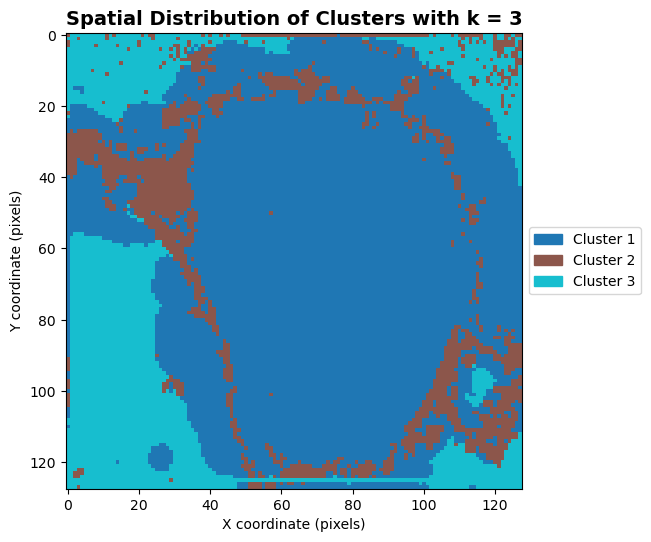

In [76]:
#  k-means clustering with k=3
print("=== K-MEANS CLUSTERING ANALYSIS ===")
print(f"Using k=3 clusters")
print(f"Data shape: {X_scaled.shape}")

# Perform clustering
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X_scaled)

# Calculate performance metrics
silhouette_avg = silhouette_score(X_scaled, labels)

print(f"\nSilhouette Score: {silhouette_avg:.4f}")

# Analyze cluster distribution
unique_labels, counts_k3 = np.unique(labels, return_counts=True)
print(f"\nCluster Distribution:")
for label, count in zip(unique_labels, counts_k3):
    percentage = count/len(labels)*100
    print(f"  Cluster {label + 1}: {count:,} pixels ({percentage:.1f}%)")

# Reshape labels back to spatial dimensions for visualization
image_width = ims_cube.shape[1]
labels_spatial_k3 = labels.reshape(height, image_width)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Main cluster map
ax1 = plt.subplot(2, 3, 1)
cluster_map = plt.imshow(labels_spatial_k3, cmap='tab10', interpolation='nearest')
plt.title('Spatial Distribution of Clusters with k = 3', fontsize=14, fontweight='bold')

# Create custom legend with cluster labels
colors = plt.cm.tab10(np.linspace(0, 1, 3))
legend_elements = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(3)]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('X coordinate (pixels)')
plt.ylabel('Y coordinate (pixels)')


## 3.4 Ergebnisse

Es wurden zwei Optionen durchgeführt. Eine mit k=3 nach einer Silhouette Score Analyse und eine mit k=5 nach Domänenwissen.

#### Hier nun die Auswertung für das Ergebnis mit k=5:
Die Cluster zeigen eine recht deutliche räumliche Strukturierung im Bild:
* Ein großes zentrales Cluster (Cluster 4, grau) dominiert den inneren Bereich der Probe.
* Cluster 1 und 5 (blaue Farbtöne) umgeben diesen Bereich ringförmig.
* Kleinere grüne Flächen (Cluster 2) treten verstreut an den Rändern auf.
* Cluster 3 (braun) findet sich hauptsächlich im äußeren Bereich der Probe.

![k5 Visualization.png](figures/k5_cluster.png)

### Quantitative Evaluation

| Cluster | Farbe    | Anteil (%) | Vermutete Geweberegion          |
|----------|-----------|-------------|----------------------------------|
| 1        | Dunkelblau| 23,38 %     | Interface-Region                |
| 2        | Grün      | 3,25 %      | Gelatine                        |
| 3        | Braun     | 21,14 %     | Glas                            |
| 4        | Grau      | 39,51 %     | Nekrotischer Tumor              |
| 5        | Hellblau  | 12,73 %     | Viabler Tumor                   |


### Diskussion der Erkenntnisse

Die entstandenen Cluster lassen sich durchaus mit den aus der Aufgabenstellung bekannten Labels beschreiben. Folgende Vermutungen:
* Der zentrale graue Bereich (Cluster 4) könnte dem nekrotischen Tumor entsprechen, da dieser typischerweise im Zentrum liegt und ein gleichmäßiges Erscheinungsbild hat.
* Das umgebende hellblaue Gebiet (Cluster 5) könnte das viables Tumorgewebe sein, da es meist die Region ist, die sich um den Nekrosebereich herum befindet.
* Die dunkelblauen Bereiche (Cluster 1) könnte die Interface-Region, also die Invasionsfront des Tumors darstellen.
* Die braunen Bereiche (Cluster 3) finden sich hauptsächlich am Rand und können daher als Glas interpretiert werden.
* Die grünen Bereiche (Cluster 2) passen gut zu der Einbettung in Gelatine, die außerhalb der biologischen Strukturen sichtbar wird.

Insgesamt zeigt das Ergebnis, dass sich trotz der rein unüberwachten Methode die resultierenden Cluster gut mit den bekannten Gewebetypen in Beziehung setzen lassen. Man beachte allerdings, dass kleinere Abweichungen vorhanden sein könnten, beispielsweise verursacht durch Überlappungen der Klassen oder  Messrauschen.

Auch sollte man nicht außer Acht lassen, dass man zwingend das Wissen darüber braucht in wie viele Cluster man das Bild einteilen möchte (also k). In diesem Anwendungsgebiet ist das eventuell nicht immer klar, da man vielleicht nicht von Beginn an weiß, ob in der Gewebeprobe beispielsweise überhaupt Krebszellen enthalten sind und daher k vielleicht nur 4 oder 3 sein sollte.

___
___
# 4. Modeling & Evaluation: PCA und Alternativen

## 4.1 PCA (Principal Component Analysis)

### 4.1.1 Daten-Standardisierung 
-> Standardisierte Daten sind bereits aus kMeans vorhanden

___
### 4.1.2 Varianzanalyse



Input data shape: (16384, 191)
PCA output shape: (16384, 191)
Number of components: 191

=== TOP COMPONENTS BREAKDOWN ===
PC 1: 0.2152 (21.52%) - Cumulative: 0.2152 (21.52%)
PC 2: 0.1309 (13.09%) - Cumulative: 0.3460 (34.60%)
PC 3: 0.0428 ( 4.28%) - Cumulative: 0.3888 (38.88%)
PC 4: 0.0230 ( 2.30%) - Cumulative: 0.4119 (41.19%)
PC 5: 0.0182 ( 1.82%) - Cumulative: 0.4301 (43.01%)
PC 6: 0.0121 ( 1.21%) - Cumulative: 0.4422 (44.22%)
PC 7: 0.0093 ( 0.93%) - Cumulative: 0.4515 (45.15%)
PC 8: 0.0089 ( 0.89%) - Cumulative: 0.4603 (46.03%)
PC 9: 0.0083 ( 0.83%) - Cumulative: 0.4686 (46.86%)
PC10: 0.0082 ( 0.82%) - Cumulative: 0.4768 (47.68%)


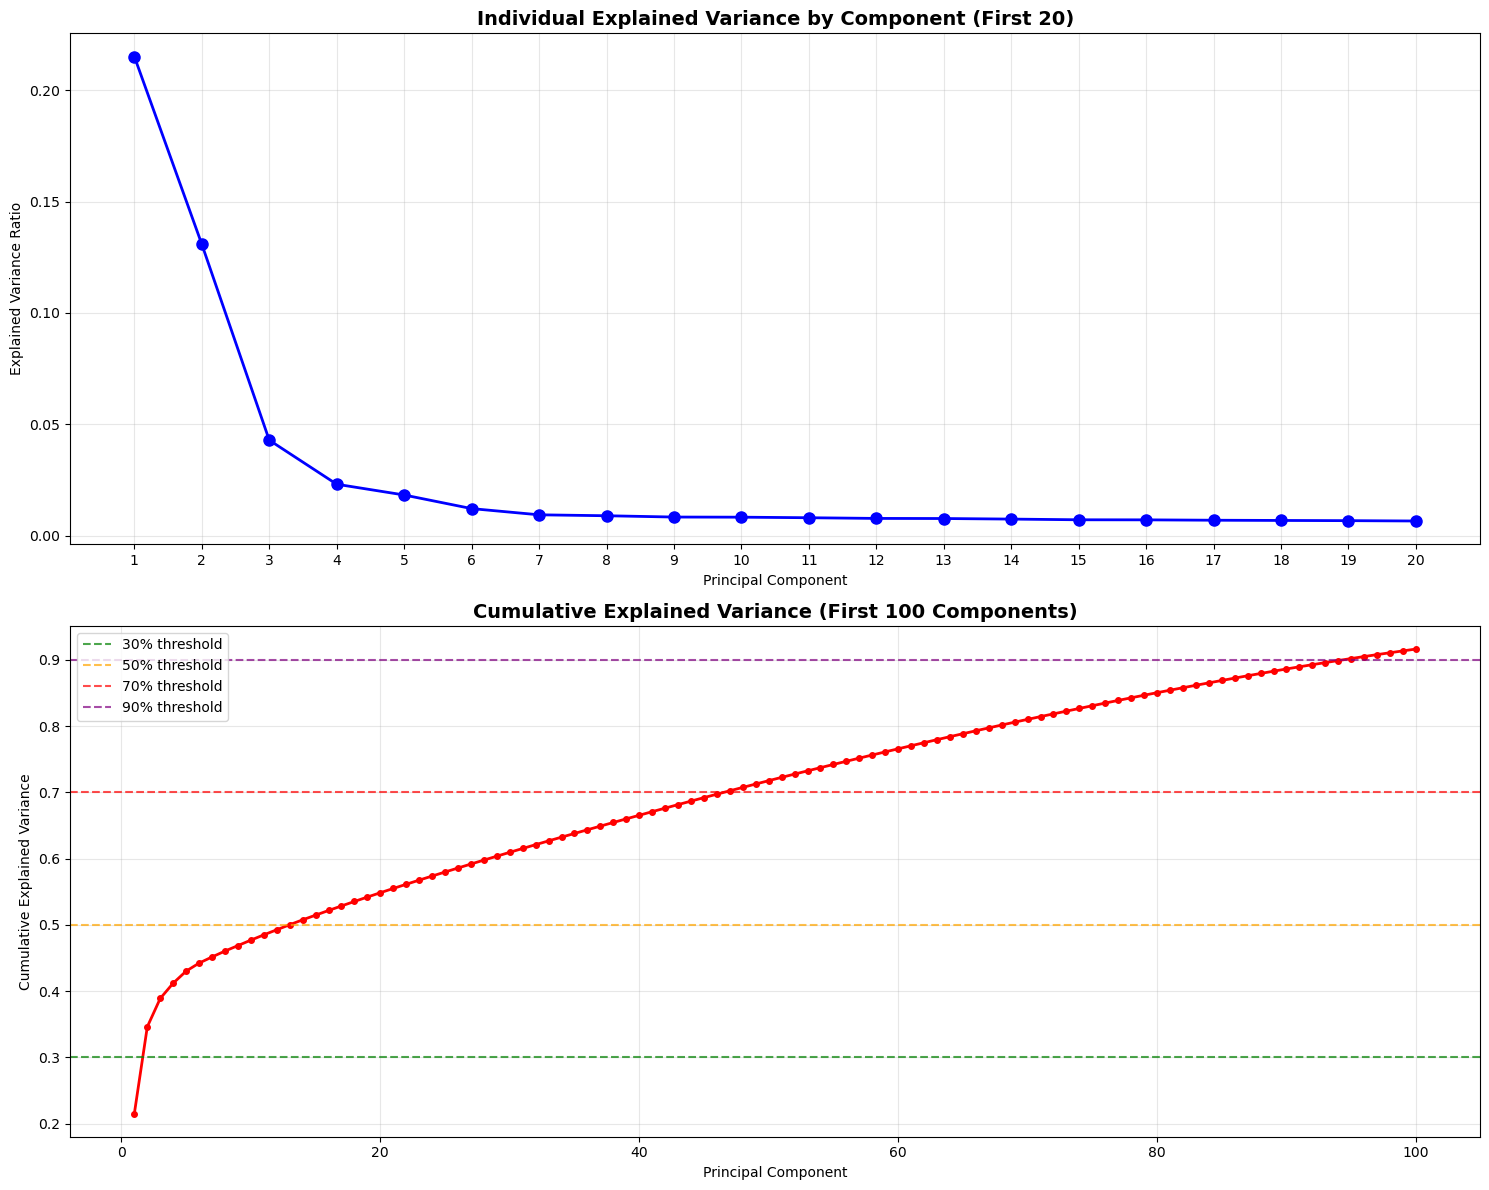

In [77]:
print(f"Input data shape: {X_scaled.shape}")

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"PCA output shape: {X_pca.shape}")
print(f"Number of components: {pca.n_components_}")

# Calculate explained variance metrics
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance = pca.explained_variance_
cumulative_variance = np.cumsum(explained_variance_ratio)


print(f"\n=== TOP COMPONENTS BREAKDOWN ===")
for i in range(min(10, len(explained_variance_ratio))):
	print(f"PC{i+1:2d}: {explained_variance_ratio[i]:.4f} ({explained_variance_ratio[i]*100:5.2f}%) "
		  f"- Cumulative: {cumulative_variance[i]:.4f} ({cumulative_variance[i]*100:5.2f}%)")

# Quick visualization of individual variance contribution (first 20 components)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Top plot: Individual variance for first 20 components
ax1.plot(range(1, 21), explained_variance_ratio[:20], 'bo-', linewidth=2, markersize=8)
ax1.set_title('Individual Explained Variance by Component (First 20)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, 21))

# Bottom plot: Cumulative variance for first 100 components
n_components_plot = min(100, len(cumulative_variance))
ax2.plot(range(1, n_components_plot + 1), cumulative_variance[:n_components_plot], 'ro-', linewidth=2, markersize=4)
ax2.axhline(y=0.30, color='g', linestyle='--', alpha=0.7, label='30% threshold')
ax2.axhline(y=0.50, color='orange', linestyle='--', alpha=0.7, label='50% threshold')
ax2.axhline(y=0.70, color='red', linestyle='--', alpha=0.7, label='70% threshold')
ax2.axhline(y=0.90, color='purple', linestyle='--', alpha=0.7, label='90% threshold')
ax2.set_title('Cumulative Explained Variance (First 100 Components)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=0.8)  # Add space between plots
plt.tight_layout()
plt.show()

In [78]:
print(f"\n=== EXPLAINED VARIANCE ANALYSIS ===")
print(f"Total variance in original data: {np.sum(explained_variance):.3f}")

# Key thresholds for dimensionality reduction
variance_thresholds = [0.30, 0.40, 0.50, 0.70, 0.90]
for threshold in variance_thresholds:
	n_components = np.argmax(cumulative_variance >= threshold) + 1
	print(f"Components needed for {threshold*100:.0f}% variance: {n_components}")

# Transform back check (reconstruction accuracy)
print(f"\n=== RECONSTRUCTION ANALYSIS ===")
# Test reconstruction with different numbers of components
n_components_test = [5, 10, 20, 50]
for n_comp in n_components_test:
	if n_comp <= pca.n_components_:
		# Reconstruct using only first n components
		X_reconstructed = X_pca[:, :n_comp] @ pca.components_[:n_comp, :]
		reconstruction_error = np.mean((X_scaled - X_reconstructed)**2)
		print(f"Reconstruction error with {n_comp} components: {reconstruction_error:.6f} "
			  f"({cumulative_variance[n_comp-1]*100:.1f}% variance retained)")


=== EXPLAINED VARIANCE ANALYSIS ===
Total variance in original data: 157.010
Components needed for 30% variance: 2
Components needed for 40% variance: 4
Components needed for 50% variance: 13
Components needed for 70% variance: 47
Components needed for 90% variance: 95

=== RECONSTRUCTION ANALYSIS ===
Reconstruction error with 5 components: 0.468474 (43.0% variance retained)
Reconstruction error with 10 components: 0.430026 (47.7% variance retained)
Reconstruction error with 20 components: 0.371211 (54.8% variance retained)
Reconstruction error with 50 components: 0.232186 (71.8% variance retained)


___
### 4.1.3 Wahl Anzahl Hauptkomponenten
#### Elbow Methode

Geht man im Plot oberhalb mit der individuellen erklärten Varianz nach der Elbow-Regel: Man sucht also den Punkt, an dem die Kurve deutlich abflacht, so ergibt es Sinn die Anzahl auf maximal 4, vielleicht sogar nur 3 Hauptkomponenten zu beschränken.

___
### 4.1.4 Plotten der räumlichen Verteilung

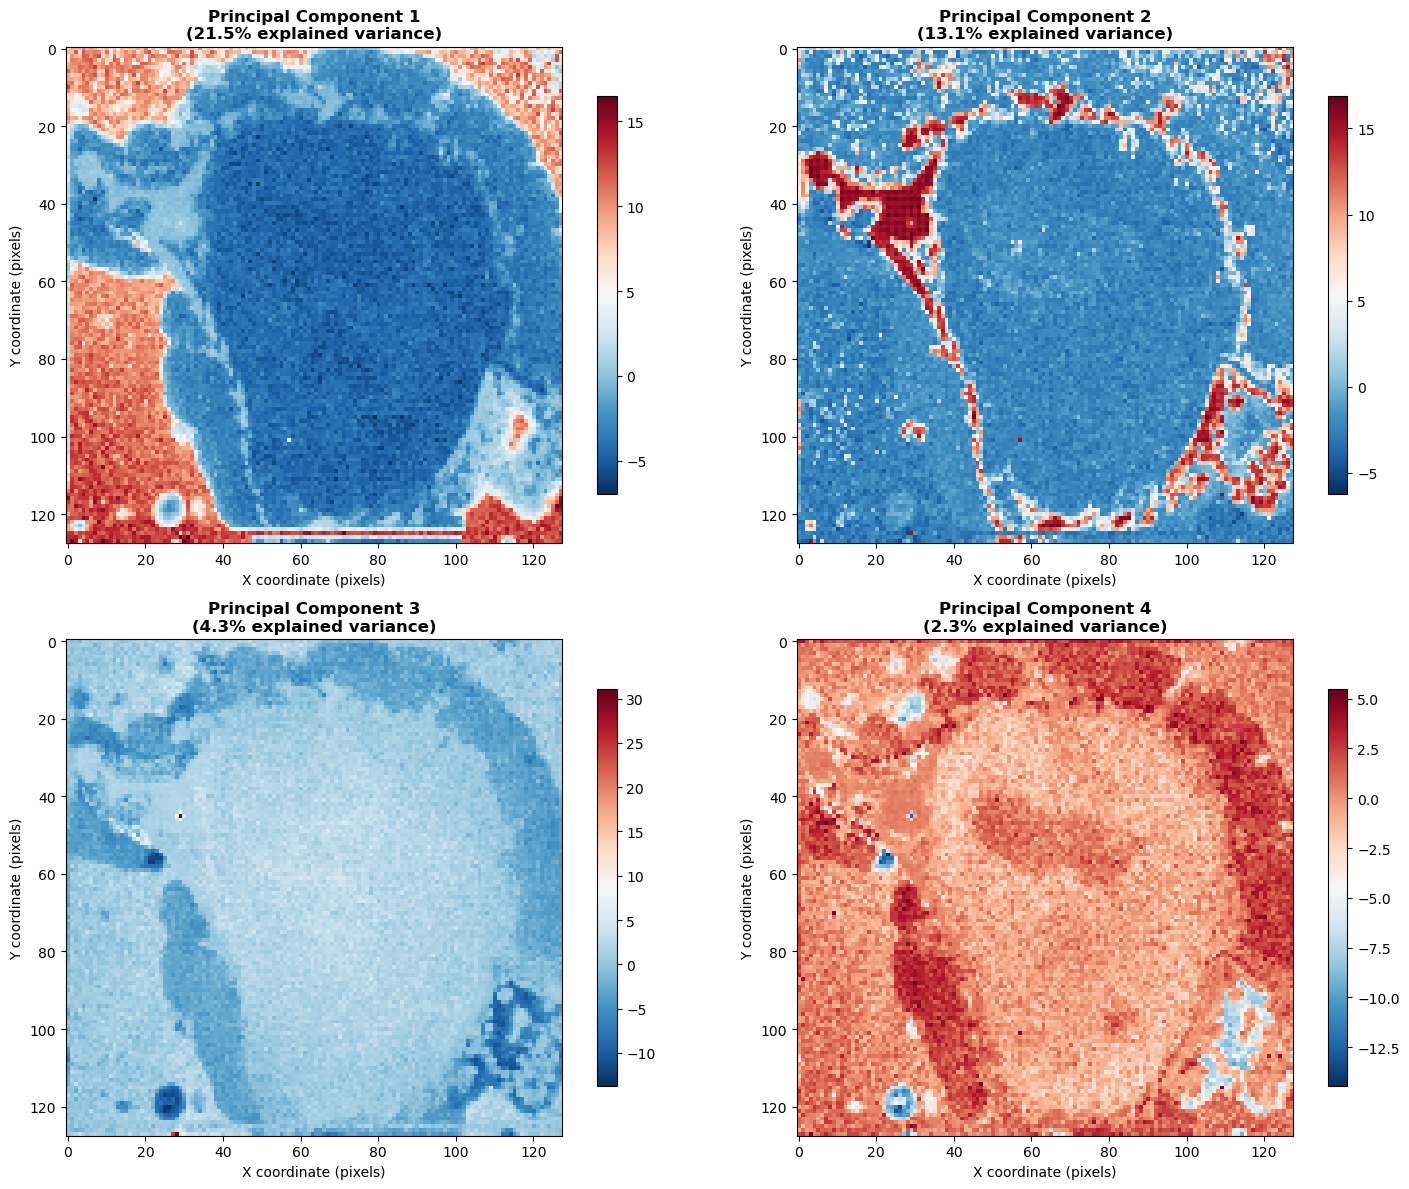

In [79]:
# Individual 128x128 spatial plots for PC 1-4
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i in range(4):
    row = i // 2
    col = i % 2
    
    # Reshape PC scores back to spatial dimensions
    pc_spatial = X_pca[:, i].reshape(height, height)
    
    # Create the plot
    im = axes[row, col].imshow(pc_spatial, cmap='RdBu_r', interpolation='nearest')
    axes[row, col].set_title(f'Principal Component {i+1}\n({explained_variance_ratio[i]:.1%} explained variance)', 
                           fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('X coordinate (pixels)')
    axes[row, col].set_ylabel('Y coordinate (pixels)')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[row, col], shrink=0.8)

plt.tight_layout()
plt.show()

___
### 4.1.5. Rekonstruktion

Beispielhaft in Folgendem auch noch dargestellt, wie die Bilder rekonstruiert nur auf Basis der ersten 4 Komponenten aussehen würden:


=== IMAGE RECONSTRUCTION WITH PC 1-4 ===
Reconstruction using 4 PCs:
  Variance retained: 0.4119 (41.19%)
  Reconstruction error (MSE): 0.483434


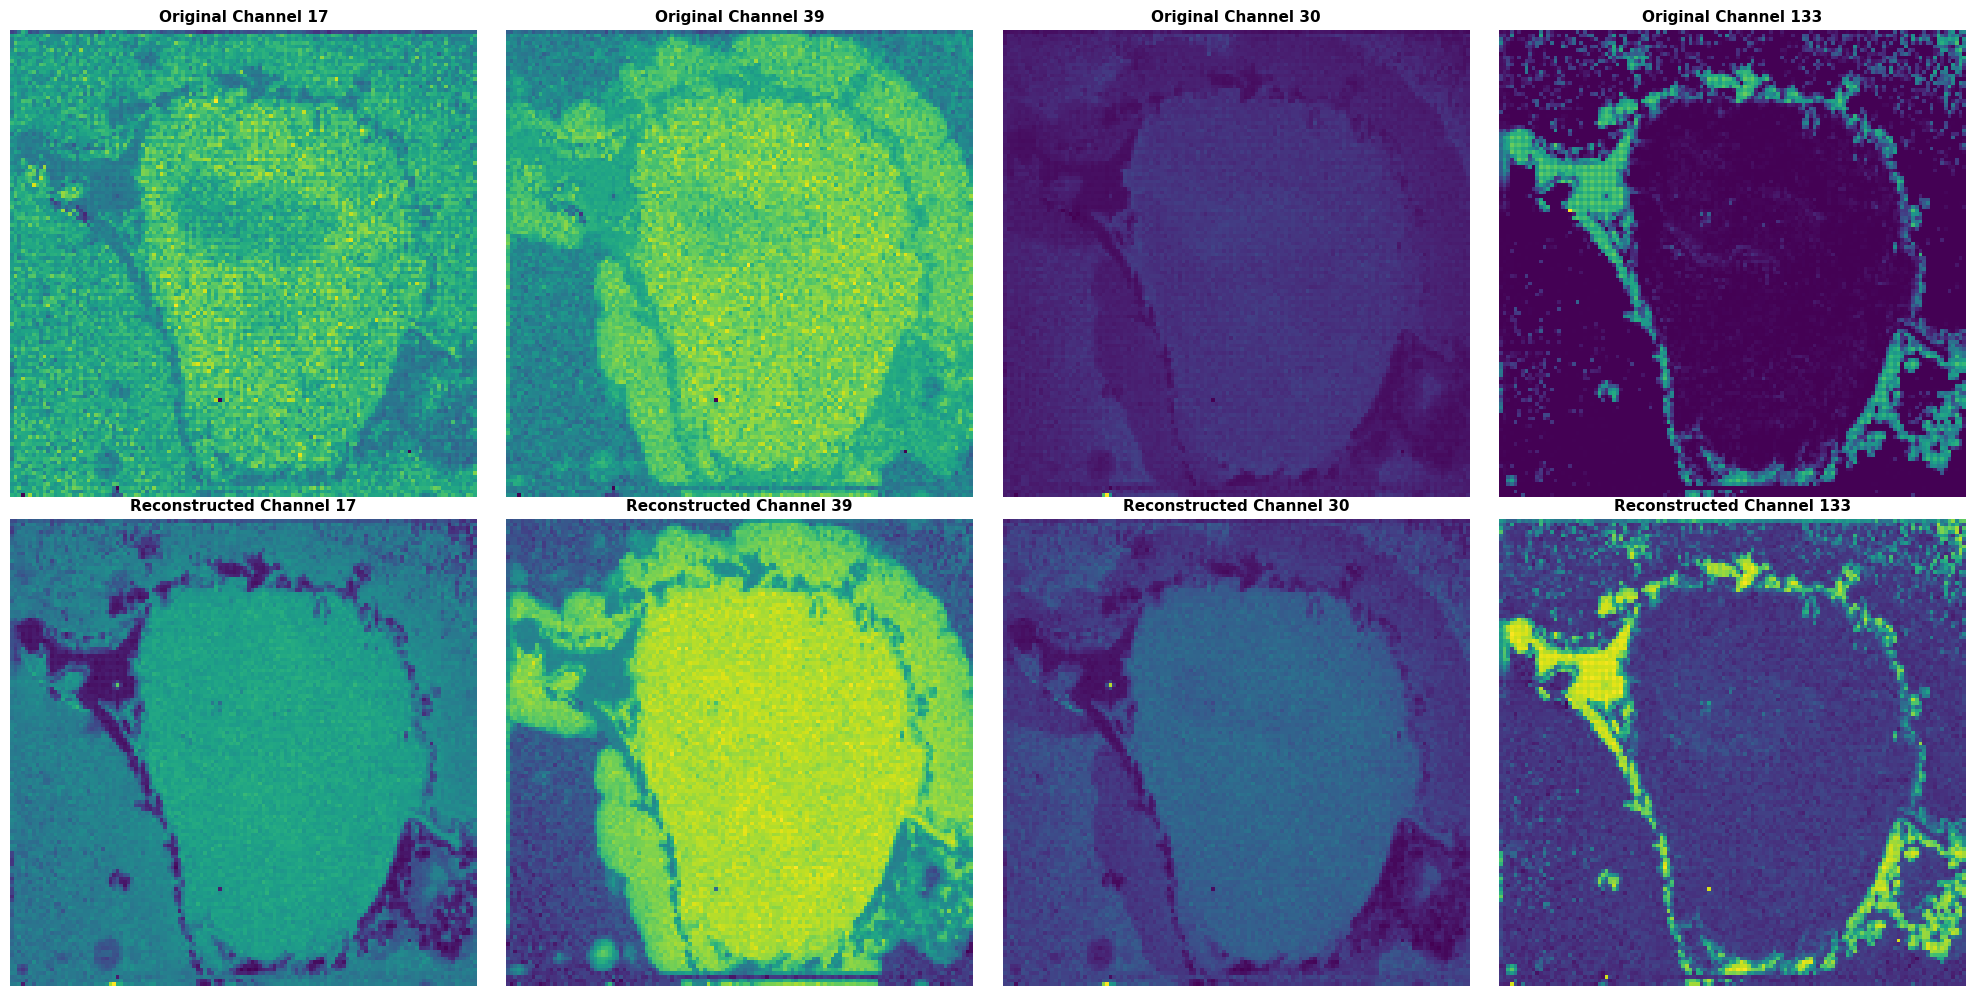

In [80]:
print(f"\n=== IMAGE RECONSTRUCTION WITH PC 1-4 ===")

# Only the first 4 PCs
X_pca_reduced = X_pca[:, :4]
pca_components_reduced = pca.components_[:4, :]

# Reconstruct the data
X_reconstructed = X_pca_reduced @ pca_components_reduced

# Calculate reconstruction quality
reconstruction_error = np.mean((X_scaled - X_reconstructed)**2)
variance_retained = cumulative_variance[3]  # Index 3 for 4th component

print(f"Reconstruction using 4 PCs:")
print(f"  Variance retained: {variance_retained:.4f} ({variance_retained*100:.2f}%)")
print(f"  Reconstruction error (MSE): {reconstruction_error:.6f}")

# Reshape reconstructed data back to original cube shape
X_reconstructed_cube = X_reconstructed.reshape(height, height, n_channels)

# Original vs Reconstructed for selected channels
channels_to_compare = [16, 38, 29, 132]  
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, channel in enumerate(channels_to_compare):
    # Original
    axes[0, idx].imshow(ims_cube[:, :, channel], cmap='viridis', interpolation='nearest')
    axes[0, idx].set_title(f'Original Channel {channel + 1}', fontsize=11, fontweight='bold')
    axes[0, idx].axis('off')
    
    # Reconstructed (inverse transform back to original scale)
    X_reconstructed_original_scale = scaler.inverse_transform(X_reconstructed)
    X_reconstructed_original_cube = X_reconstructed_original_scale.reshape(height, height, n_channels)
    
    axes[1, idx].imshow(X_reconstructed_original_cube[:, :, channel], cmap='viridis', interpolation='nearest')
    axes[1, idx].set_title(f'Reconstructed Channel {channel + 1}', fontsize=11, fontweight='bold')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

Man sieht, dass die einzelnen Kanäle deutlich klarere Bilder abzeichnen. Das unterstreicht auch, warum es sinnvoll sein kann, die PCA dem kMeans Clustering vorzuschieben.

___
### 4.1.6 Ergebnisdiskussion

#### PC1 (21.5% erklärte Varianz)
<img src="figures/PC01.png" alt="PC1" width="400">

**Räumliches Muster:** 
PC1 erfasst das dominanteste Muster im Datensatz. Es zeigt einen starken Kontrast zwischen dem zentralen Bereich (Blau, negativer Score) und der äußeren Umgebung (Rot, positiver Score).

**Deutung:** Dieses PC beschreibt die größte chemische Unterscheidung im Bild, also sehr wahrscheinlich die Trennung zwischen der biologischen Probe und dem Hintergrund bzw. dem Trägermaterial. Innerhalb des zentralen blauen Bereichs sind ebenso nochmal Trennungen ersichtlich. Beim Vergleich mit den Beispielbildern könnte möglicherweise der innere, dunklere Bereich der nekrotische Tumor sein, die hellblaue Umrandung der viable Tumor und das dunkelblaue Gewebe drumherum die Interface Region.


#### PC2 (13.1% erklärte Varianz)
<img src="figures/PC2.png" alt="PC2" width="400">


**Räumliches Muster:** PC2, das orthogonal zu PC1 steht, erfasst die zweitgrößte Varianz. Das Muster fokussiert sich wie es scheint nun auf die Heterogenität innerhalb des zentralen Gewebes. Es trennt bestimmte Zwischenstrukturen (Rot) vom Rest des Gewebes (Blau).

**Deutung:** Dieses PC identifiziert die zweitgrößte chemische Unterscheidung im Bild, welche nun innerhalb des Gewebes zu sein scheint. Daher erlaubt es nun, das Gewebe genauer zu untersuchen. Die klar abgegrenzte Rote Fläche könnte wie auch bei PC1 schon vermutet den viablen Tumor darstellen.


#### PC3 (4.3% erklärte Varianz)
<img src="figures/PC3.png" alt="PC3" width="400">

**Räumliches Muster:** Das Muster ist weniger deutlich und zeigt vor allem subtile und fleckige Unterschiede im Gewebe. Alles ist im negativen, blauen Score Bereich.

**Deutung:** Die dunkleren Flecken tauchen eher am Rand auf, was im Vergleich zu den Beispielbildern Gelatine darstellen könnte. Die weniger intensiven Bereiche könnten verdeutlichen, dass die Gelatine überall in der Probe verteilt ist und nur an manchen stellen klar abgrenzbar ist.


#### PC4 (2.3% erklärte Varianz)
<img src="figures/PC4.png" alt="PC4" width="400">

**Räumliches Muster:** Dieses PC zeigt die geringfügigste Varianz. Die strukturen sind schwächer voneinander abgegrenzt und möglicherweise spielt hier schon das Rauschen eine größere Rolle. Dennoch ist eine klare dunkelrotere Region wahrzunehmen. Interessanterweise sind innerhalb der inneren hellroten Fläche, welche zuvor als Nekrotischer Tumor gedeutet wurde, zwei dunklere Flächen zu sehen, welche zuvor nie aufgetaucht sind.

**Deutung:** Die dunkelrote Region lässt sich deckend mit den Vermutungen von zuvor als viabler Tumor interpretieren. Das erscheinen der beiden Flecken im Inneren des vermuteten nekrotischen Gewebes würde allerdings gegen die bisherigen Vermutungen sprechen. Man könnte es so interpretieren, dass dort vielleicht der tatsächliche nekrotische Tumor liegt und die in diesem PC hellrote Fläche dann möglicherweise der viable Tumor umgeben von Interface Region ist. Allerdings war bei der Bestimmung der Anzahl der PCs schon nicht klar, ob es sich lohnt PC4 überhaupt mit aufzunehmen. Daher müsste man überlegen, ob es sinnvoll ist die bisherige Deutung aufgrund einer Beobachtung in diesem PC komplett zu ändern.

___
### 4.1.7 Vor- und Nachteile des PCA-Ansatzes

| **Aspekt** | **Vorteile** | **Nachteile** |
|:-----------|:-------------|:--------------|
| **Dimensionsreduktion**       | Drastische Reduktion von 148 auf 4 Komponenten bei 41.3% Varianzerhaltung     | Verlust von 58.7% der ursprünglichen Information |
| **Interpretierbarkeit**       | Klare räumliche Muster in den ersten PCs erkennbar                            | Spätere PCs (PC3-4) schwer interpretierbar; mögliche Vermischung von Signal und Rauschen |
| **Recheneffizienz**           | Deutlich schnellere Verarbeitung und geringerer Speicherbedarf für nachgelagerte Analysen | Zusätzlicher Rechenaufwand für PCA-Transformation selbst |
| **Rauschreduktion**           | Eliminierung von Rauschen in den weniger wichtigen Komponenten | Möglicher Verlust schwacher aber wichtiger Signale |
| **Clustering-Vorbereitung**   | Bessere Separierbarkeit der Gewebetypen durch Fokus auf Hauptvarianzrichtungen | K-Means könnte direkt auf Originaldaten andere Cluster finden |
| **Visualisierung**            | Schöne 2D-Darstellung der Hauptmuster möglich | Strukturen müssen manuell interpretiert werden -> kein fertiges Clusterbild |
| **Datenqualität**             | Rekonstruierte Bilder zeigen klarere Strukturen als Originaldaten | Verluste durch unvollständige Rekonstruktion möglich |



___
___
## 4.2 NMF (Non-negative Matrix Factorization)

### 4.2.1 Daten-Standardisierung 
-> auch hier: Standardisierte Daten sind bereits aus kMeans vorhanden

___
### 4.2.2 Reconstruction Error Analyse

Für NMF muss eine andere Art der Analyse durchgeführt werden, da dort keine erklärten Varianzen wie bei der PCA zur verfügung stehen. Alternativ eignet sich der Reconstruction Error:




=== NMF RECONSTRUCTION & CUMULATIVE ANALYSIS ===
Baseline error (no components): 0.821990
Calculating reconstruction errors for 1 to 20 components...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(



=== TOP COMPONENTS BREAKDOWN (NMF) ===
NMF 1: Error=0.794434, Quality=0.0335 ( 3.35%)
NMF 2: Error=0.619356, Quality=0.2465 (24.65%)
NMF 3: Error=0.534035, Quality=0.3503 (35.03%)
NMF 4: Error=0.503157, Quality=0.3879 (38.79%)
NMF 5: Error=0.487731, Quality=0.4066 (40.66%)
NMF 6: Error=0.484010, Quality=0.4112 (41.12%)
NMF 7: Error=0.470802, Quality=0.4272 (42.72%)
NMF 8: Error=0.462587, Quality=0.4372 (43.72%)
NMF 9: Error=0.458908, Quality=0.4417 (44.17%)
NMF10: Error=0.458001, Quality=0.4428 (44.28%)


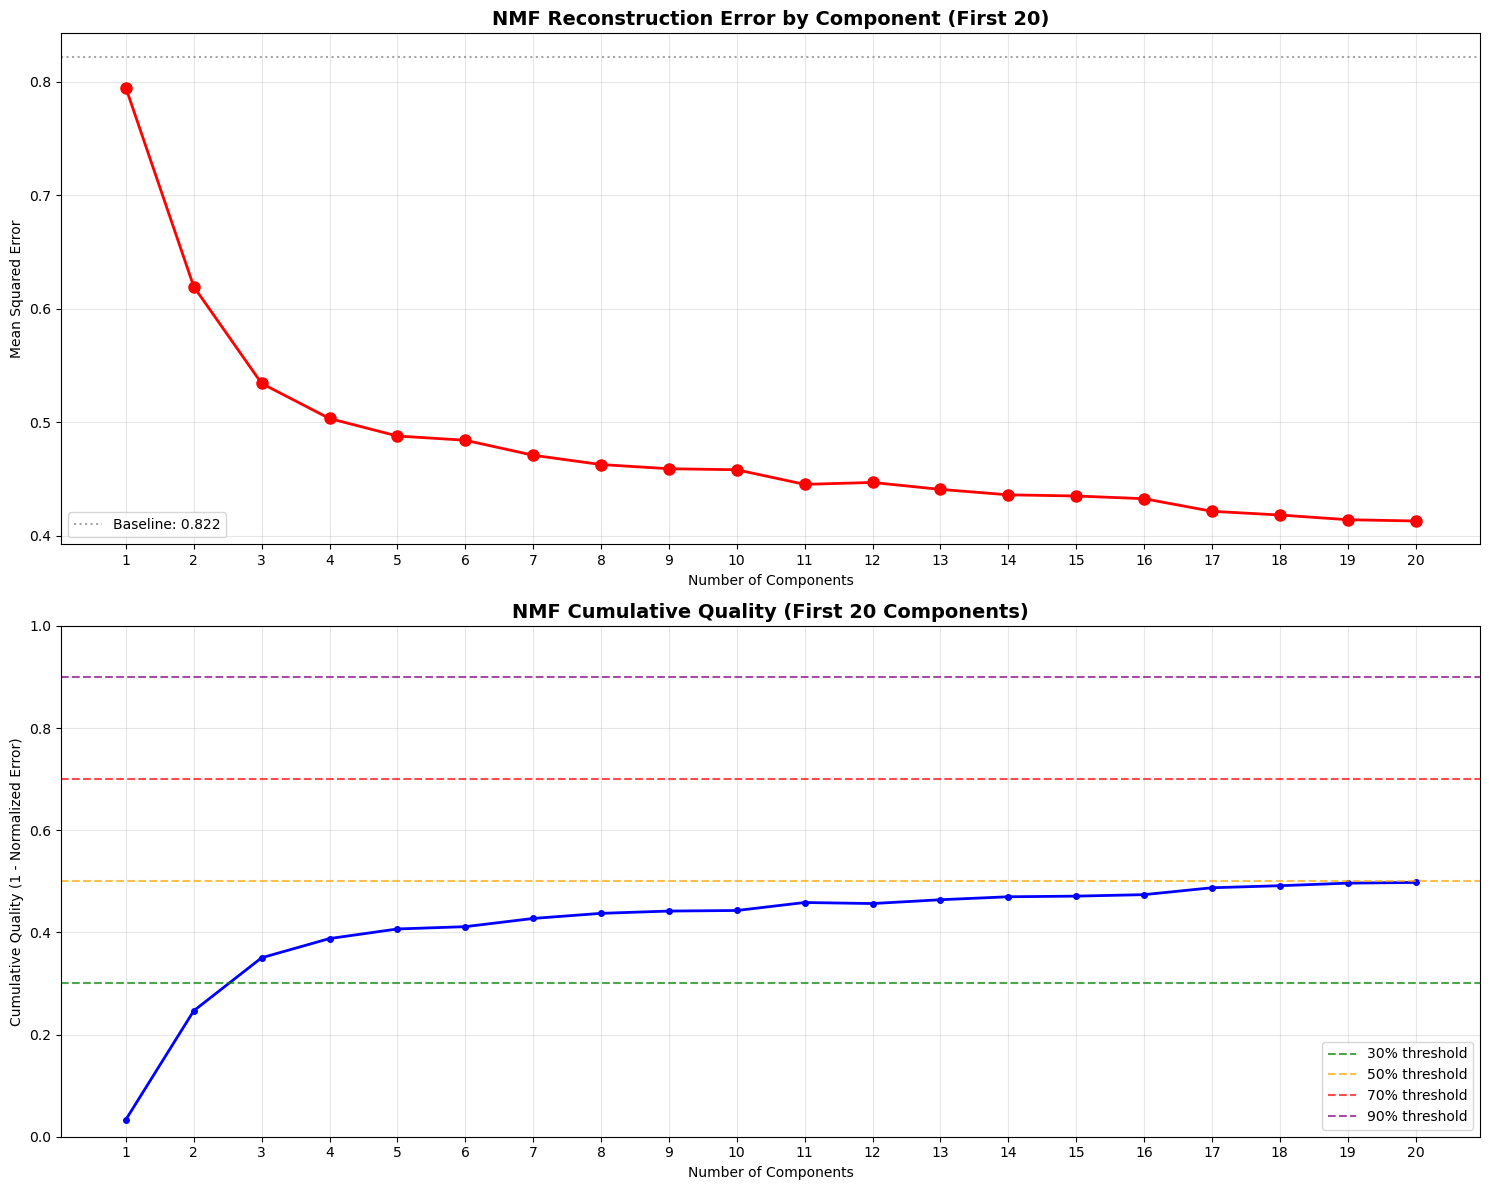

In [ ]:
print(f"\n=== NMF RECONSTRUCTION & CUMULATIVE ANALYSIS ===")

# Calculate baseline error (no reconstruction - just using mean)
baseline_error = np.mean((X_shifted - np.mean(X_shifted))**2)
print(f"Baseline error (no components): {baseline_error:.6f}")

# Calculate reconstruction errors for different numbers of components (1 to 20)
max_components = min(20, n_channels)
reconstruction_errors = []
cumulative_quality = []
components_range = range(1, max_components + 1)

print(f"Calculating reconstruction errors for 1 to {max_components} components...")

for n_comp in components_range:
    # Fit NMF with n_comp components
    nmf_temp = NMF(n_components=n_comp, random_state=42, max_iter=500)
    X_temp = nmf_temp.fit_transform(X_shifted)
    X_reconstructed = X_temp @ nmf_temp.components_
    
    # Calculate reconstruction error
    error = np.mean((X_shifted - X_reconstructed)**2)
    reconstruction_errors.append(error)
    
    # Calculate cumulative quality (1 - normalized error relative to baseline)
    normalized_error = error / baseline_error
    cumulative_quality.append(1 - normalized_error)

print(f"\n=== TOP COMPONENTS BREAKDOWN (NMF) ===")
for i in range(min(10, len(reconstruction_errors))):
    print(f"NMF{i+1:2d}: Error={reconstruction_errors[i]:.6f}, Quality={cumulative_quality[i]:.4f} ({cumulative_quality[i]*100:5.2f}%)")

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Top plot: Reconstruction error for first 20 components
ax1.plot(range(1, len(reconstruction_errors) + 1), reconstruction_errors, 'ro-', linewidth=2, markersize=8)
ax1.axhline(y=baseline_error, color='gray', linestyle=':', alpha=0.7, label=f'Baseline: {baseline_error:.3f}')
ax1.set_title('NMF Reconstruction Error by Component (First 20)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Mean Squared Error')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, len(reconstruction_errors) + 1))
ax1.legend()

# Bottom plot: Cumulative quality for first 20 components
ax2.plot(range(1, len(cumulative_quality) + 1), cumulative_quality, 'bo-', linewidth=2, markersize=4)
ax2.axhline(y=0.30, color='g', linestyle='--', alpha=0.7, label='30% threshold')
ax2.axhline(y=0.50, color='orange', linestyle='--', alpha=0.7, label='50% threshold')
ax2.axhline(y=0.70, color='red', linestyle='--', alpha=0.7, label='70% threshold')
ax2.axhline(y=0.90, color='purple', linestyle='--', alpha=0.7, label='90% threshold')
ax2.set_title('NMF Cumulative Quality (First 20 Components)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Quality (1 - Normalized Error)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)
ax2.set_xticks(range(1, len(cumulative_quality) + 1))

plt.subplots_adjust(hspace=0.8)
plt.tight_layout()
plt.show()

___
### 4.2.3 Wahl Anzahl Komponenten
#### Elbow Methode

Geht man im Plot oberhalb mit dem individuellen Construction Error nach der Elbow-Regel, so ergibt es Sinn die Anzahl auf maximal 4-5 Hauptkomponenten zu beschränken.

___
### 4.2.4 Plotten der räumlichen Verteilung

=== NON-NEGATIVE MATRIX FACTORIZATION ===
Input data shape: (16384, 191)
Data shifted to non-negative range: [0.000, 57.683]
NMF output shape: (16384, 5)


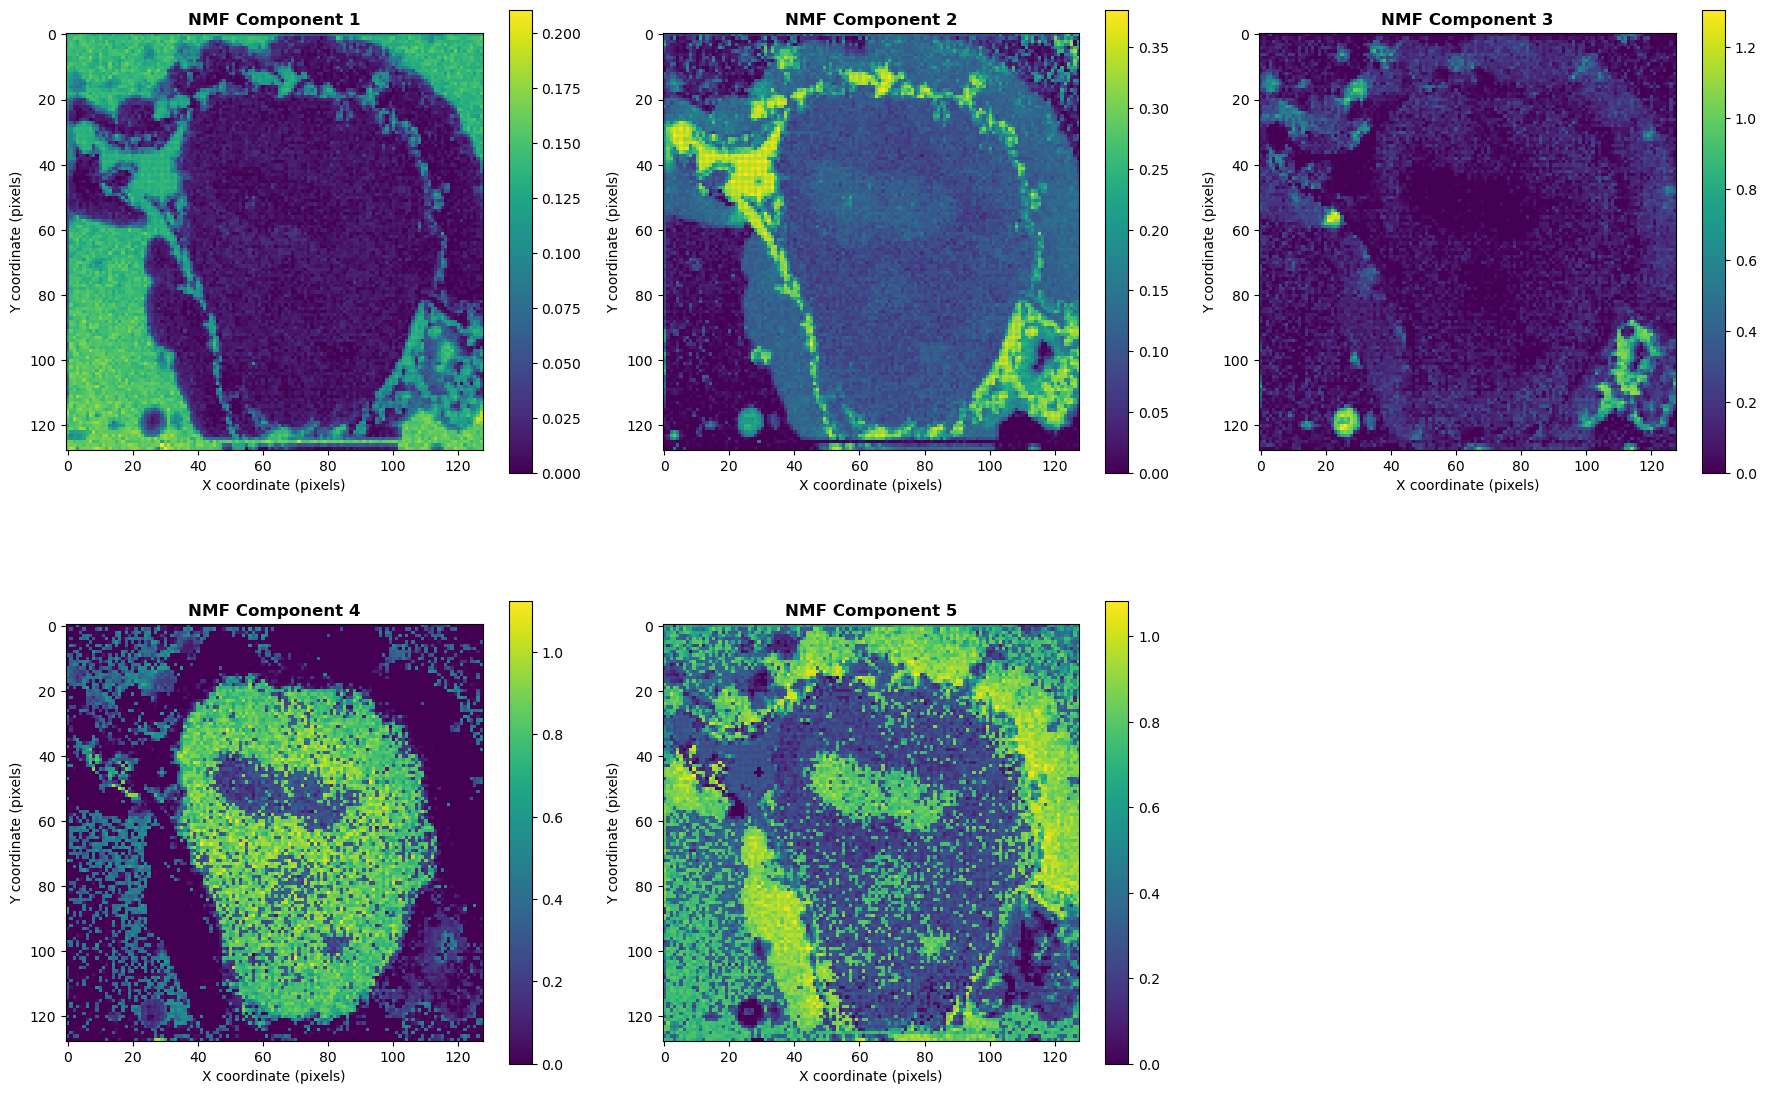

In [81]:
# Perform NMF on standardized data
print("=== NON-NEGATIVE MATRIX FACTORIZATION ===")
print(f"Input data shape: {X_scaled.shape}")

# NMF requires non-negative data, so we need to shift the standardized data
# Add the minimum value to make all values non-negative
X_shifted = X_scaled - np.min(X_scaled)
print(f"Data shifted to non-negative range: [{np.min(X_shifted):.3f}, {np.max(X_shifted):.3f}]")

# Apply NMF with reduced dimensionality
n_components_nmf = 5  # Use same number of components as ICA for comparison

# Apply NMF
nmf = NMF(n_components=5, random_state=42, max_iter=1000)
X_nmf = nmf.fit_transform(X_shifted)

print(f"NMF output shape: {X_nmf.shape}")


# Plot the top 5 NMF components spatially
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i in range(5):
    row = i // 3
    col = i % 3
    
    # Reshape NMF scores back to spatial dimensions
    nmf_spatial = X_nmf[:, i].reshape(height, image_width)
    
    # Create the plot
    im = axes[row, col].imshow(nmf_spatial, cmap='viridis', interpolation='nearest')
    axes[row, col].set_title(f'NMF Component {i+1}', 
                           fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('X coordinate (pixels)')
    axes[row, col].set_ylabel('Y coordinate (pixels)')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[row, col], shrink=0.8)

# Hide the last subplot since we only have 5 components
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()

___
### 4.2.5 Rekonstruktion

Analog zur PCA beispielhaft in Folgendem dargestellt, wie die Bilder rekonstruiert nur auf Basis der ersten 5 Komponenten aussehen würden:


=== IMAGE RECONSTRUCTION WITH NMF 1-5 ===
Reconstruction using 5 NMF components:
  Reconstruction error (MSE): 0.487731


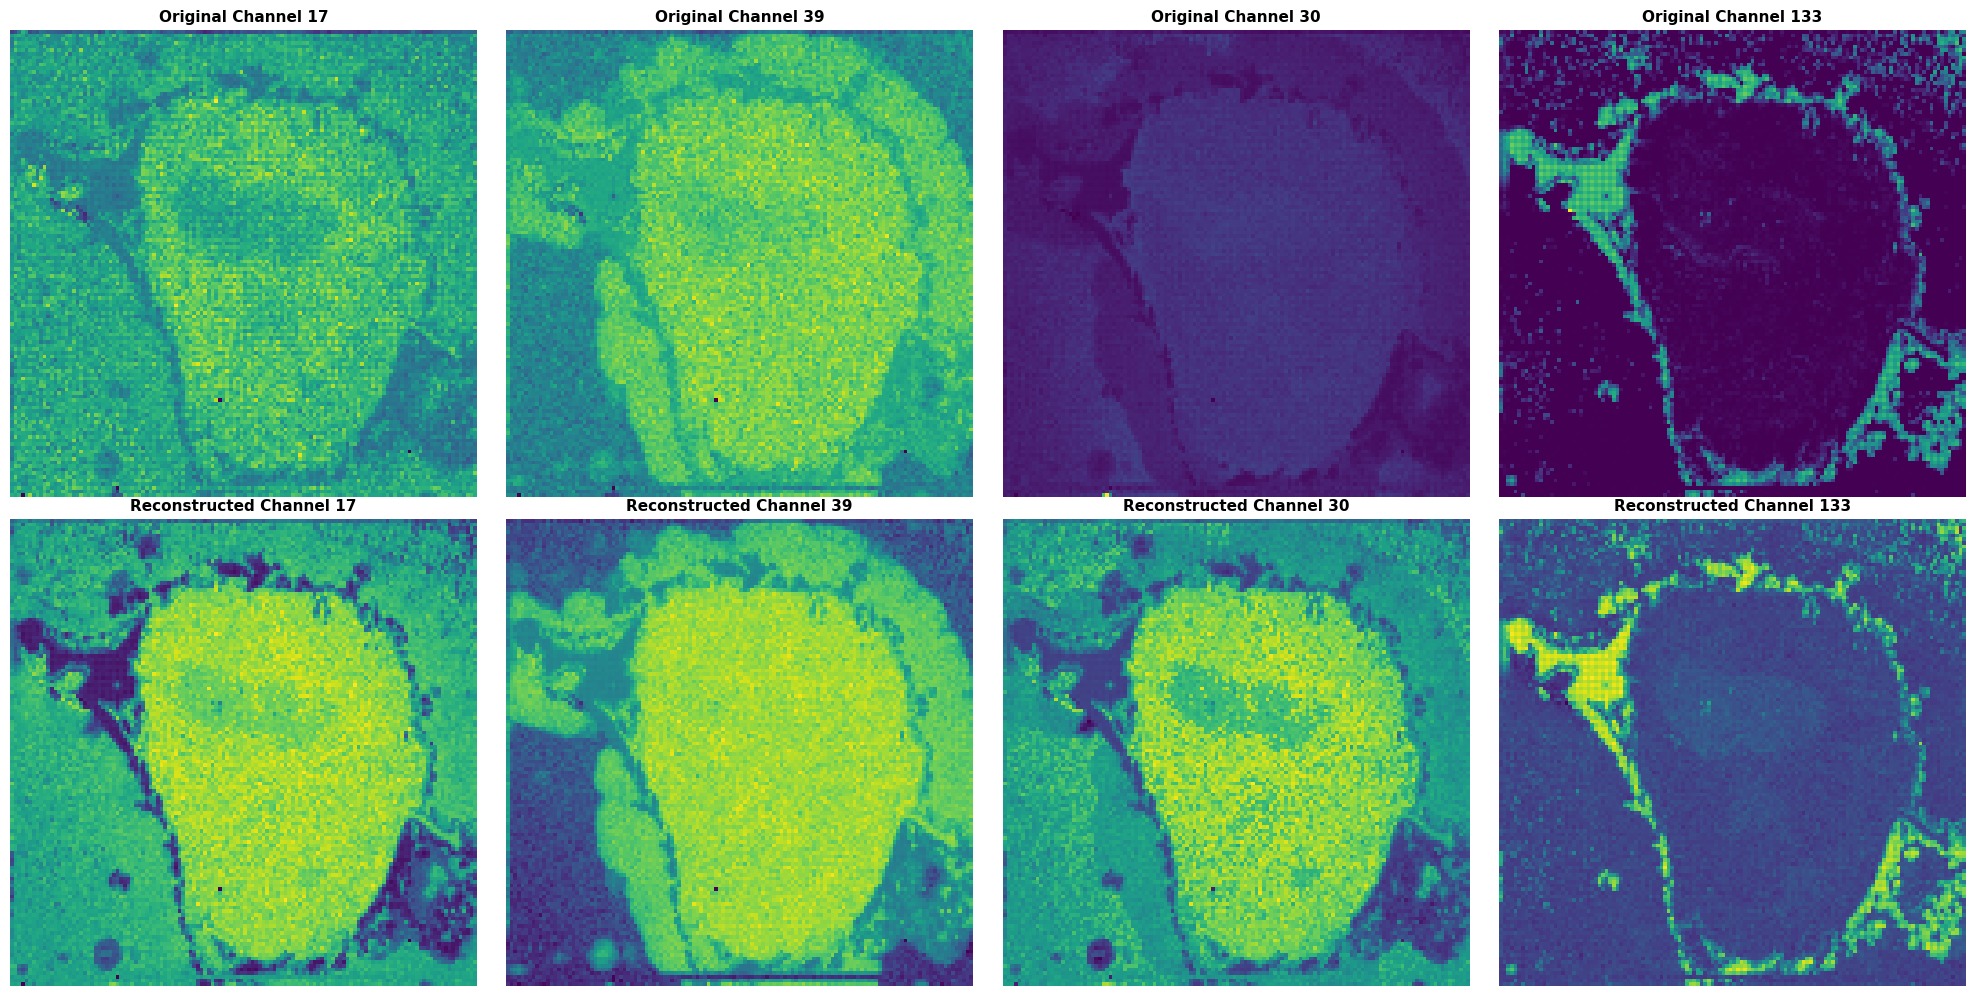

In [85]:
print(f"\n=== IMAGE RECONSTRUCTION WITH NMF 1-5 ===")

# Only the first 5 NMF components
X_nmf_reduced = X_nmf[:, :5]
nmf_components_reduced = nmf.components_[:5, :]

# Reconstruct the data
X_reconstructed_nmf = X_nmf_reduced @ nmf_components_reduced

# Calculate reconstruction quality
reconstruction_error_nmf = np.mean((X_shifted - X_reconstructed_nmf)**2)

print(f"Reconstruction using 5 NMF components:")
print(f"  Reconstruction error (MSE): {reconstruction_error_nmf:.6f}")

# Reshape reconstructed data back to original cube shape
X_reconstructed_nmf_cube = X_reconstructed_nmf.reshape(height, height, n_channels)

# Original vs Reconstructed for selected channels
channels_to_compare = [16, 38, 29, 132]  
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, channel in enumerate(channels_to_compare):
    # Original
    axes[0, idx].imshow(ims_cube[:, :, channel], cmap='viridis', interpolation='nearest')
    axes[0, idx].set_title(f'Original Channel {channel + 1}', fontsize=11, fontweight='bold')
    axes[0, idx].axis('off')
    
    # Reconstructed (shift back and inverse transform to original scale)
    X_reconstructed_unshifted = X_reconstructed_nmf + np.min(X_scaled)
    X_reconstructed_original_scale = scaler.inverse_transform(X_reconstructed_unshifted)
    X_reconstructed_original_cube = X_reconstructed_original_scale.reshape(height, height, n_channels)
    
    axes[1, idx].imshow(X_reconstructed_original_cube[:, :, channel], cmap='viridis', interpolation='nearest')
    axes[1, idx].set_title(f'Reconstructed Channel {channel + 1}', fontsize=11, fontweight='bold')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()


___
### 4.2.6 Ergebnisdiskussion
#### Deutung durch einzelne Komponenten 

Die einzelnen Komponenten ähneln stark den PCs aus der PCA. Daher wäre der Deutungsversuch in diesem Fall nahezu Deckungsgleich und wird an dieser Stelle nicht nochmals wiederholt.

Eine interessante Beobachtung ist, dass die Struktur, die bei der PCA erst im vierten PC aufgetaucht ist und daher in der Deutung eher vernachlässigt wurde bei der NMF schon früher und deutlicher sichtbar ist. Daher hätte man hier nun durchaus Anlass die Deutung so zu drehen, dass dieser unten rot markierte Bereich eventuell dem nekrotischen Tumor, umrandet von viablem Tumor entspricht, der wiederum von einer Interface-Region umschlossen ist wie es auch unter 4.1.6 bei der Deutung von PCA schon kurz beschrieben war.

<img src="figures/nmf_marked.png" alt="NMF">

___
### 4.2.7 Vor- und Nachteile des NMF-Ansatzes

| **Aspekt** | **Vorteile** | **Nachteile** |
|:-----------|:-------------|:--------------|
| **Dimensionsreduktion**       | Reduktion von 148 auf 5 Komponenten mit guter Rekonstruktionsqualität     | Kein direktes Maß für erklärte Varianz wie bei PCA verfügbar |
| **Interpretierbarkeit**       | Non-negative Komponenten ermöglichen direktere physikalische Interpretation      | Komponenten sind nicht orthogonal → mögliche Redundanz zwischen Komponenten |
| **Recheneffizienz**           | Moderate Rechenzeit; gut parallelisierbar | Iterativer Algorithmus → längere Laufzeit als PCA; Konvergenz nicht garantiert |
| **Rauschreduktion**           | Natürliche Sparse-Kodierung kann Rauschen reduzieren | Weniger mathematisch fundierte Rauschunterdrückung als PCA |
| **Visualisierung**            | Klar abgrenzbare räumliche Regionen; frühere Sichtbarkeit wichtiger Strukturen | Schwieriger zu verstehen ohne Domänenwissen über Non-negative Constraints |
| **Datenqualität**             | Erhaltung der additiven Struktur der Spektraldaten; biologisch plausiblere Zerlegung | Erfordert Datenvorverarbeitung (Shift zu non-negativen Werten) |
| **Sparsity**                  | Natürliche Tendenz zu sparse Repräsentationen → klarere Strukturen | Kann wichtige schwache Signale übermäßig unterdrücken |

___
___
## 4.3 Fazit

Die Analyse der MSI-Daten zeigt, dass verschiedene Verfahren zu unterschiedlichen Interpretationsmöglichkeiten führen:

k-Means Clustering liefert direkt interpretierbare Gewebesegmente, die sich gut mit den bekannten Gewebetypen (nekrotischer Tumor, viabler Tumor, Interface-Region, etc.) korrelieren lassen. Die räumliche Zuordnung ist eindeutig und die biologische Deutung relativ straightforward.

PCA und NMF als Dimensionsreduktionsverfahren erfordern dagegen eine komplexere Interpretation. Die einzelnen Komponenten müssen erst analysiert und ihre räumlichen Muster in Relation zu den erwarteten Gewebestrukturen gesetzt werden. Interessant ist dabei, dass:

* PCA mathematisch fundierte, orthogonale Komponenten liefert mit klarer Varianzaufklärung
* NMF durch die Non-Negativitäts-Constraints biologisch plausiblere "Basis-Spektren" erzeugt und wichtige Strukturen früher sichtbar macht

### Schlussfolgerung:
Während Clustering-Verfahren direktere, intuitive Ergebnisse liefern, bieten Dimensionsreduktionsverfahren tiefere Einblicke in die Datenstruktur, erfordern aber mehr Expertise für die korrekte Interpretation. Die Kombination beider Ansätze (z.B. PCA als Vorverarbeitung für k-Means) kann die Vorteile beider Welten vereinen.

___
___
# 5. Business Understanding und Deployment

## 5.1 Pitch
### Das Problem – Histologie ist ganz schön zäh

Wenn man Gewebeproben analysieren will – zum Beispiel in der Krebsdiagnostik oder bei der Wirkstoffentwicklung – steckt da eine Menge Aufwand drin. Man muss sie chemisch färben, und die Auswertung hängt oft stark davon ab, wer draufschaut. Außerdem fehlen manchmal einfach die passenden Marker oder Labels.

Die moderne MSI-Technologie (Mass Spectrometry Imaging) liefert zwar extrem viele Informationen (pro Pixel gleich hunderte molekulare Features), aber das ist eben so nur eine Datenflut, die man ohne smarte Methoden kaum sinnvoll auswerten kann.

### Die Idee – „MSI Insight“
Unsere Lösung ist ein KI-gestützter Analyse-Service, der diese MSI-Daten automatisch in Gewebekarten übersetzt. „MSI Insight“ erkennt selbstständig, welche Gewebetypen vorkommen (z.B. lebendes Tumorgewebe vs. nekrotisches Tumorgewebe) und zeigt, wie sie verteilt sind – und das Ganze in Minuten statt Stunden. So bekommen Pathologen oder Biologen direkt einen klaren Überblick, ohne sich durch endlose Rohdaten zu quälen.

### Wie’s funktioniert – der technische Kern
Unter der Haube setzen wir auf unüberwachtes Lernen, also Verfahren, die auch ohne vorherige Labels auskommen:
1.	**Tissue Segmentation mit k-means:**
Wenn man schon eine grobe Ahnung hat, wie viele verschiedene Gewebetypen vorkommen, nutzen wir k-Means, um die Pixel anhand ihrer Spektren in Cluster einzuteilen. So bekommt man schnell eine klare Segmentierung des Gewebes.

2.	**Molekulare Dekomposition mit PCA und NMF:**
Wenn die Analyse tiefer gehen soll – also nicht nur Cluster, sondern auch zugrundeliegende molekulare Strukturen und Zusammenhänge sichtbar werden sollen – setzen wir auf PCA und NMF.\
PCA hilft dabei, die wichtigsten Variationen in den Daten herauszufiltern, während NMF zusätzlich nicht-negative Komponenten liefert, die physikalisch sinnvollere und interpretierbarere molekulare Signaturen ergeben.


___
## 5.2 Business Model Canvas

<table style="width:100%; border-collapse: collapse; text-align: left;">
  <tr>
    <!-- Row 1: Key Partnerships, Key Activities, Value Propositions, Customer Relationships, Customer Segments -->
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top; width: 20%;">
      <h3>Key Partnerships</h3><br>
      <strong>MSI-Gerätehersteller:</strong> Sicherstellung der Datenkompatibilität<br><br>
      <strong>Universitäten und Forschungslabore:</strong> Zugang zu seltenen, qualitativ hochwertigen Datensätzen<br><br>
      <strong>Cloud-Anbieter:</strong> Bereitstellung von skalierbarer Rechenleistung
    </td>
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top; width: 20%;">
      <h3>Key Activities</h3><br>
      <strong>Modell-Training und Validierung:</strong> Kontinuierliche Entwicklung der Algorithmen<br><br>
      <strong>Cloud-Infrastruktur:</strong> Aufbauen und Warten<br><br>
      <strong>Forschung und Entwicklung:</strong> Implementierung neuer Methoden
    </td>
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top; width: 20%">
      <h3>Value Propositions</h3><br>
      <strong>Geschwindigkeit & Objektivität:</strong> Automatisierte Klassifizierung beschleunigt die Analyse um bis zu 80% und eliminiert manuelle, subjektive Schritte<br><br>
      <strong>Tiefere Einsichten:</strong> Identifikation unbekannter Gewebetypen-Mischverhältnisse durch Dekompositionsmethoden (PCA, NMF)<br><br>
      <strong>Kostensenkung:</strong> Reduzierung des Bedarfs an aufwändigen, chemischen Färbemethoden
    </td>
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top; width: 20%;">
      <h3>Customer Relationships</h3><br>
      <strong>Automatisierter Self-Service:</strong> Plattformzugang<br><br>
      <strong>Dedizierter Support und Beratung:</strong> für Feature Engineering und Algorithmus-Parameter-Abstimmung<br><br>
      <strong>Bildungsangebote:</strong> Kurse / Weiterbildung für Data Science Verständnis
    </td>
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top; width: 20%;">
      <h3>Customer Segments</h3><br>
      <strong>Pathologische Labore/Kliniken:</strong> Schnelle, objektive Tumordiagnostik und Grading<br><br>
      <strong>Pharma- und Biotechnologieunternehmen:</strong> Beschleunigte Biomarker-Entdeckung und präklinische Forschung<br><br>
      <strong>MSI-Gerätehersteller:</strong> Lizenzierung der Software als integraler Bestandteil ihrer Hardware-Plattform
    </td>
  </tr>
  <tr>
    <!-- Row 2: Key Resources spanning 2 columns, Channels spanning 2 columns -->
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top;">
      <!-- Empty cell for spacing -->
    </td>
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top;">
      <h3>Key Resources</h3><br>
      <strong>Algorithmen:</strong> Clustering, PCA, NMF und eventuell weitere Verfahren<br><br>
      <strong>Data Science Expertise</strong><br><br>
      <strong>MSI-Trainingsdaten:</strong> Umfangreiche Sammlung (gelabelt und ungelabelt)
    </td>
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top;">
      <!-- Empty middle cell for spacing -->
    </td>
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top;">
      <h3>Channels</h3><br>
      <strong>Direktvertrieb:</strong> über Sales-Team<br><br>
      <strong>Cloud-Plattform:</strong> Sichere Online-Schnittstelle<br><br>
      <strong>Strategische Partnerschaften:</strong> mit MSI-Hardware-Anbietern
    </td>
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top;">
      <!-- Empty cell for spacing -->
    </td>
  </tr>
  <tr>
    <!-- Row 3: Cost Structure spanning 2 columns, Revenue Streams spanning 2 columns -->
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top;" colspan="2">
      <h3>Cost Structure</h3><br>
      <strong>Forschung und Entwicklung:</strong> Gebäudemiete, Personal, Gehälter, Geräte<br><br>
      <strong>Computing-Kosten:</strong> Rechenzentren/Cloud-Services, aufgrund der rechenintensiven Verarbeitung großer Datensätze
    </td>
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top;">
      <!-- Empty middle cell for spacing -->
    </td>
    <td style="border: 2px solid #333; padding: 15px; vertical-align: top;" colspan="2">
      <h3>Revenue Streams</h3><br>
      <strong>Subscription-Modell (SaaS):</strong> Jährliche Gebühr pro Arbeitsplatz oder Gebühr pro analysierter Probe<br><br>
      <strong>Lizenzgebühren:</strong> Lizenzierung des Algorithmus an große Pharmaunternehmen für die interne Nutzung
    </td>
  </tr>
</table>